In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import math
import librosa
import json
import wave
import sys
import pickle
import sklearn

import urllib.request

import librosa.display
import scipy, matplotlib.pyplot as plt, IPython.display as ipd

from scipy.io import wavfile

import librosa.display
import soundfile as sf

import torch
import torchaudio
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import os
import matplotlib.style as ms
from tqdm import tqdm
import random
ms.use('seaborn-muted')
%matplotlib inline

## Audio dataset

In [2]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, sampling_rate=44100, wav_files_path='Audio_preprocess/', meta_data="df_prep.csv", shuffle=False):
        self.emotion_dict = {'ang': 0,
                             'dis': 1,
                             'hap': 2,
                             'sad': 3,
                             'sca': 4,
                             'sur': 5,
                             'neu': 6
                            }
        
        self.wav_files_path = wav_files_path
        self.sr = sampling_rate
        self.shuffle = shuffle
        self.meta_data = pd.read_csv(meta_data).to_numpy()
        
    def getAudio(self, file_path):
        wav_vector, _sr = librosa.load(file_path, sr=self.sr)
#         wav_vector, _sr = torchaudio.load(file_path)
        """
        TODO: implement later needed processing of wav vector
        """
        
        try:
#             feature_vector = torchaudio.transforms.MelSpectrogram(_sr)(wav_vector)
            feature_vector = librosa.feature.melspectrogram(y=wav_vector, sr=_sr)
            feature_vector = torch.from_numpy(feature_vector).permute(1, 0)
        except:
            print(file_path)
            raise
        return feature_vector
                
    def __getitem__(self, index):
        file_path = self.meta_data[index][0]
        emotion = self.emotion_dict[self.meta_data[index][1]]
        emotion = torch.tensor(emotion)
        return self.getAudio(file_path), emotion

    def __len__(self):
        return len(self.meta_data)

In [3]:
dataset = AudioDataset()
train_loader = DataLoader(dataset, num_workers=1, shuffle=False,
                              batch_size=1)

for batch in dataset:
    x, y= batch
    if x.size(0) == 0:
#         print(x.shape, y.shape)
        print(x)
    break

## Train toolset

In [6]:
def train_cycle(model, optimizer, loss_func, n_epoch, train_loader, validation_loader, device):
    model.train()
    epoch_losses = []
    epoch_losses_val = []
    for epoch in range(n_epoch):
        print("Epoch: {}".format(epoch))
        losses = []
        for batch in tqdm(train_loader):
            model.zero_grad()
            optimizer.zero_grad()
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
            y_pred = model(x)
            y_pred = y_pred.to(device)
#             print(y_pred.shape, y.shape)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        epoch_losses.append(np.mean(losses))
        
        fig = plt.figure(figsize=(14,5))
        ax1 = fig.add_subplot(121)
        plt.plot(epoch_losses)
        plt.title("Loss")
        
#         validation_losses = []
#         with torch.no_grad():
#             for i, batch in enumerate(validation_loader):
#                 x, y = batch
#                 x = x.to(device)
#                 y = y.to(device)

#                 y_pred = model(x)
#                 y_pred = y_pred.to(device)
                
                
#                 loss = loss_func(y_pred, y)
#                 validation_losses.append(loss.item())
#             epoch_losses_val.append(np.mean(losses))
    return epoch_losses, epoch_losses_val, model

In [7]:
def train(model, dataset, loss_func=None, lr=0.001, n_epoch=1000, batch_size=4, shuffle=True, validation_split=.15):
    if loss_func is None:
        loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    print("Loading data")
#     validation_split = .15
    shuffle_dataset = shuffle
    random_seed= 42

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1,
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1,
                                                    sampler=valid_sampler)
    try:
        train_loss, val_loss, best_model = train_cycle(model, optimizer, loss_func, n_epoch, train_loader, validation_loader, device)
    except KeyboardInterrupt:
        print("Keyboard interrupt, continue work")
        return
    except:
        print("Something went wrong")
        raise
    return train_loss, val_loss, best_model

In [8]:
class LSTMClassifier(nn.Module):
    """docstring for LSTMClassifier"""
    def __init__(self, config):
        super(LSTMClassifier, self).__init__()
        self.n_layers = config['n_layers']
        self.input_dim = config['input_dim']
        self.hidden_dim = config['hidden_dim']
        self.output_dim = config['output_dim']
        self.bidirectional = config['bidirectional']
        self.dropout = config['dropout'] if self.n_layers > 1 else 0

        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, bias=True,
                           num_layers=1, dropout=self.dropout,
                           bidirectional=self.bidirectional)
        self.out = nn.Linear(self.hidden_dim, self.output_dim)
        self.softmax = F.softmax

    def forward(self, input_seq):
        # input_seq =. [1, batch_size, input_size]
        rnn_output, (hidden, _) = self.rnn(input_seq)
        if self.bidirectional:  # sum outputs from the two directions
            rnn_output = rnn_output[:, :, :self.hidden_dim] +\
                        rnn_output[:, :, self.hidden_dim:]
        out = self.out(rnn_output[0])
        print(out.shape)
        class_scores = F.softmax(out) 
        return class_scores

In [9]:
class AttentionModel(torch.nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, embedding_length):
        super(AttentionModel, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 

        --------

        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
#         self.vocab_size = vocab_size
        self.embedding_length = embedding_length

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
#         self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        self.lstm = nn.LSTM(embedding_length, hidden_size)
        self.label = nn.Linear(hidden_size, output_size)
        #self.attn_fc_layer = nn.Linear()

    def attention_net(self, lstm_output, final_state):

        """ 
        Now we will incorporate Attention mechanism in our LSTM model. In this new model, we will use attention to compute soft alignment score corresponding
        between each of the hidden_state and the last hidden_state of the LSTM. We will be using torch.bmm for the batch matrix multiplication.

        Arguments
        ---------

        lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
        final_state : Final time-step hidden state (h_n) of the LSTM

        ---------
    
        Returns : It performs attention mechanism by first computing weights for each of the sequence present in lstm_output and and then finally computing the
                  new hidden state.

        Tensor Size :
                hidden.size() = (batch_size, hidden_size)
                attn_weights.size() = (batch_size, num_seq)
                soft_attn_weights.size() = (batch_size, num_seq)
                new_hidden_state.size() = (batch_size, hidden_size)

        """

        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state

    def forward(self, input, batch_size=None):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
    
        Returns
        -------
        Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
        final_output.shape = (batch_size, output_size)

        """

#         input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        if batch_size is None:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cpu())
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cpu())
        else:
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cpu())
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cpu())
#         if batch_size is None:
#             h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
#             c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
#         else:
#             h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
#             c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())

        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
        output = output.permute(1, 0, 2) # output.size() = (batch_size, num_seq, hidden_size)

        attn_output = self.attention_net(output, final_hidden_state)
        logits = self.label(attn_output)

        return logits

In [10]:
# config = {
#     'gpu': 0,
#     'bidirectional': False,
#     'input_dim': 128,
#     'hidden_dim': 50,
#     'output_dim': 7,  # number of classes
#     'dropout': 0.2,
#     'learning_rate': 0.001,
#     'batch_size': 1,  # carefully chosen
#     'n_epochs': 55000,
#     'n_layers': 2,
#     'model_code': 'basic_lstm'
# }
# model = LSTMClassifier(config)

model = AttentionModel(batch_size=1, output_size=7, hidden_size=32, embedding_length=128)
dataset = AudioDataset()

  0%|          | 0/512 [00:00<?, ?it/s]

Loading data
Epoch: 0


100%|██████████| 512/512 [01:50<00:00,  4.64it/s]


([1.8763692944776267], [], AttentionModel(
   (lstm): LSTM(128, 32)
   (label): Linear(in_features=32, out_features=7, bias=True)
 ))

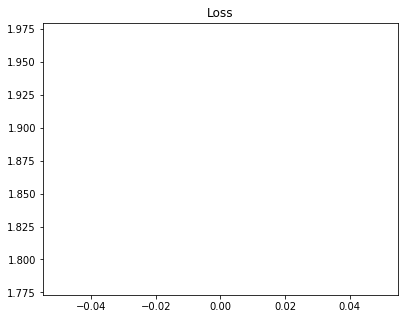

In [11]:
train(model, dataset, batch_size=1, n_epoch=1, validation_split=.95)

In [ ]:
train_loader = DataLoader(dataset, num_workers=1, shuffle=False,
                              batch_size=1)

for batch in dataset:
    x, y= batch
    if x.size(0) == 0:
#         print(x.shape, y.shape)
        print(x)
#     break